(10, 1) (10, 2)


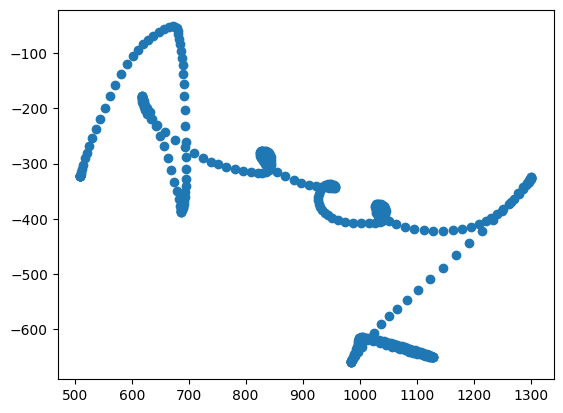

In [1]:
import numpy as np
import json

from plotting import plot_signals

from preprocess import preprocess

with open("data/signatures.txt") as f:
	signatures = json.load(f)
	np_signatures = np.array(signatures)

signals = [preprocess(np_signature) for np_signature in np_signatures]
plot_signals(signals)

signal = signals[0]

In [2]:
# !pip install --upgrade scipy==1.8.0
import scipy
print(scipy.__version__) # 1.8.0

1.8.0


In [3]:
from speed_extract import extract_sigma_lognormal, get_point_combos, get_stroke_combos, mark_stroke_candidates

candidates=mark_stroke_candidates(signal)

candidate=candidates[0]
point_combos=get_point_combos(candidate)
point_combo = point_combos[0]
print([str(pt) for pt in point_combo])

stroke_combos = get_stroke_combos(candidate)
stroke_combo = stroke_combos[0]
print([str(pt) for pt in stroke_combo])

print(extract_sigma_lognormal(point_combo,stroke_combo))

['Point(role=2,idx=15,time=485.0,speed=2.4044708300781963,angle=5.059140184622986)', 'Point(role=3,idx=21,time=515.0,speed=4.3088534112003005,angle=5.191876694965923)']
['Point(role=1,idx=4,time=430.0,speed=-0.08867940749078607,angle=1.9961343381730003)', 'Point(role=2,idx=15,time=485.0,speed=2.4044708300781963,angle=5.059140184622986)', 'Point(role=3,idx=21,time=515.0,speed=4.3088534112003005,angle=5.191876694965923)', 'Point(role=4,idx=27,time=545.0,speed=3.0314722625666284,angle=5.373990518181836)', 'Point(role=5,idx=35,time=585.0,speed=1.0852355318856906,angle=7.005233558991913)']
LognormalStroke(D=329.5791910185019,t_0=319.6021762503524,mu=5.298851718704676,sigma=0.15431823149018792,theta_s=4.986124993159854,theta_f=None)


In [4]:
from beam_search import BeamSearch

top_k = 10
snr_threshold = 1000 # I have no idea what to say for this.
max_strokes = 14
search = BeamSearch(signal,top_k,snr_threshold,max_strokes)

out_stroke = search.search()